In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from tqdm import tqdm

In [3]:
dat = pd.read_csv('./data/training_set_VU_DM.csv')

# Data set

In [5]:
dat.shape

(4958347, 54)

The training set consists of 4958347 instances and 54 features, 
which makes this a fairly large set to work with.
It would probably be best to work with batches of the data set to test our models.

In [6]:
dat.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


From dat.head() we can immediatly notice that some features might not be that useful.
- srch_id: is used to group the instances but most likely provide no predictive value.
- site_id: same as srch_id.
- visitor_location_country_id: would be useful if could actually map it to actual countries, but right now is probably not very useful on its own.
- prop_country_id: same as previous country id. However, if these features have the same mapping, we could actually try to find some relation.
- prop_id: we have no mapping so this is most likely not useful.
- comp_xrate: the competitor features can be really useful but might contain a huge amount of NA values.


# Analytics

### NA values

In [24]:
dat.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

It can be seen that some features contain a huge amount of NA values. It should be noted that it makes sense for some features to have a large number of NA's. The gross_bookings_usd variable for example should only be filled when the search actually resulted in a booking.

In [27]:
dat_booked = dat[dat['booking_bool'] == 1]
print(dat_booked.shape)
dat_booked.isnull().sum()

(138390, 54)


srch_id                             0
date_time                           0
site_id                             0
visitor_location_country_id         0
visitor_hist_starrating        129302
visitor_hist_adr_usd           129256
prop_country_id                     0
prop_id                             0
prop_starrating                     0
prop_review_score                 116
prop_brand_bool                     0
prop_location_score1                0
prop_location_score2            14474
prop_log_historical_price           0
position                            0
price_usd                           0
promotion_flag                      0
srch_destination_id                 0
srch_length_of_stay                 0
srch_booking_window                 0
srch_adults_count                   0
srch_children_count                 0
srch_room_count                     0
srch_saturday_night_bool            0
srch_query_affinity_score      127505
orig_destination_distance       44689
random_bool 

We can see that the number of NA's dropped to zero for the gross_bookings_usd and lowered for the other features, which makes sense as the number of instances dropped as well.

In [33]:
nas = pd.DataFrame({'booked':dat_booked.isnull().sum(),'all':dat.isnull().sum()})
nas['na_perc_booked'] = nas['booked']/dat_booked.shape[0]
nas['na_perc_all'] = nas['all']/dat.shape[0]
nas

,booked,all,na_perc_booked,na_perc_all
srch_id,0,0,0.000000,0.000000
date_time,0,0,0.000000,0.000000
site_id,0,0,0.000000,0.000000
visitor_location_country_id,0,0,0.000000,0.000000
visitor_hist_starrating,129302,4706481,0.934331,0.949204
visitor_hist_adr_usd,129256,4705359,0.933998,0.948977
prop_country_id,0,0,0.000000,0.000000
prop_id,0,0,0.000000,0.000000
prop_starrating,0,0,0.000000,0.000000
prop_review_score,116,7364,0.000838,0.001485


We can again see that there is no actual difference in the number of NA's for whole data set and filter for booked only. 

### Correlation

In [7]:
dat.corr()['srch_adults_count']

srch_id                        0.004007
site_id                       -0.022573
visitor_location_country_id    0.002687
visitor_hist_starrating       -0.011558
visitor_hist_adr_usd           0.039195
prop_country_id                0.028440
prop_id                        0.000213
prop_starrating                0.006948
prop_review_score              0.019175
prop_brand_bool                0.006918
prop_location_score1           0.019014
prop_location_score2           0.002969
prop_log_historical_price     -0.010369
position                      -0.009098
price_usd                      0.001955
promotion_flag                 0.017321
srch_destination_id           -0.000952
srch_length_of_stay            0.011260
srch_booking_window            0.110007
srch_adults_count              1.000000
srch_children_count            0.096640
srch_room_count                0.471428
srch_saturday_night_bool       0.063918
srch_query_affinity_score     -0.005124
orig_destination_distance     -0.020818


It can be seen that there is no clear linear correlation to be found. A simple linear predictor will therefore not work.

# Batches

Since the data set is fairly large, we will work with a batch of data. It will consist of 10000 srch_id's which will result in 248543 instances.

In [20]:
unique_srch = dat.srch_id.unique()
sel_srch_id = random.sample(list(unique_srch),10000)
sel_dat = dat[dat.srch_id.isin(sel_srch_id)]
sel.shape

# Price - booking comparison

The dataset is really large right now. Let's first try to find some basic analytics with just some of the variables.

In [3]:
hotel_data = dat[['prop_id','price_usd','visitor_location_country_id','visitor_hist_starrating','visitor_hist_adr_usd', 'click_bool', 'booking_bool', 'gross_bookings_usd','srch_length_of_stay','srch_adults_count', 'srch_children_count']].sort_values('prop_id')
hotel_data = hotel_data[hotel_data['booking_bool'] != 0]
hotel_data['booking_p_night'] = hotel_data['gross_bookings_usd']/hotel_data['srch_length_of_stay']
hotel_data['booking_p_person'] = hotel_data['gross_bookings_usd']/(hotel_data['srch_children_count'] + hotel_data['srch_adults_count'])
hotel_data['booking_p_night_person'] = hotel_data['gross_bookings_usd']/hotel_data['srch_length_of_stay']/(hotel_data['srch_children_count'] + hotel_data['srch_adults_count'])

We made new variables to try compare the booking with the previous booking in the 'visitor_hist_adr_usd' variable. We first use Pearson's correlation test. 

In [4]:
hotel_data[['visitor_hist_adr_usd','booking_p_night','booking_p_person','booking_p_night_person']].corr()

,visitor_hist_adr_usd,booking_p_night,booking_p_person,booking_p_night_person
visitor_hist_adr_usd,1.000000,0.290151,0.109992,0.262573
booking_p_night,0.290151,1.000000,0.534495,0.836849
booking_p_person,0.109992,0.534495,1.000000,0.604983
booking_p_night_person,0.262573,0.836849,0.604983,1.000000


A convincing correlation cannot be found. This makes sense as we have no information about the previous booking, just the price per night. Based on that information, the booking_p_night variable should be the most comparible, but is barely better than the others. 

# KNN hotel clustering

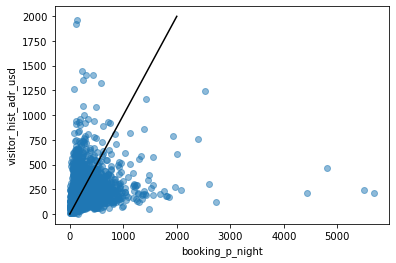

In [5]:
x = np.arange(0,2000)
y = np.arange(0,2000)
plt.scatter(hotel_data['booking_p_night'],hotel_data['visitor_hist_adr_usd'], alpha=0.5)
plt.plot(x,y, color = 'black')
plt.xlabel('booking_p_night')
plt.ylabel('visitor_hist_adr_usd')
plt.show()

This plot shows the same result, it is really hard to find some linear relation here. 

There are multiple type of hotels with multiple dimensions of data. We can try to perform a k-means clustering algorithm to cluster the hotels.

In [6]:
hotel_clustering = dat[['prop_country_id','prop_starrating','prop_review_score','prop_brand_bool','prop_location_score1','prop_location_score2','prop_log_historical_price','price_usd','promotion_flag']].dropna()

The elbow method is a useful graphical tool to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to.
The idea behind the elbow method is to identify the value of k where the distortion begins to decrease most rapidly, which will become clearer if we plot the distortion for different values of k.
https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

1
2
3
4
5
6
7
8
9
10


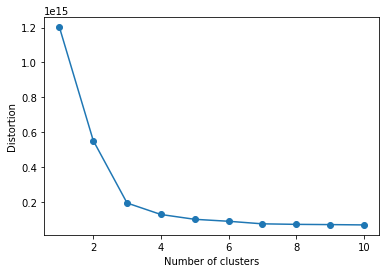

In [7]:
distortions = []
for i in range(1, 11):
    print(i)
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(hotel_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

We can see in the resulting plot that the turning point is at k = 3, which means k = 3 is a good choice for the kmeans algorithm. 

# Combining competitor data

In [30]:
comp_col = [col for col in dat if col.endswith('rate')]

dat['comp_rate'] = -2
dat['comp_rate'] = dat['comp_rate'].replace(-2,np.NaN)

for c in tqdm(comp_col):
    mask_1 = dat[c] == 1
    mask_0 = dat[c] == 0
    mask_minus_1 = dat[c] == -1
    dat.loc[mask_1, 'comp_rate'] = 1
    dat.loc[mask_0, 'comp_rate'] = 0
    dat.loc[mask_minus_1, 'comp_rate'] = -1


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 14.76it/s]


In [37]:
comp_col.append('comp_rate')
dat[comp_col].head(60)

,comp1_rate,comp2_rate,comp3_rate,comp4_rate,comp5_rate,comp6_rate,comp7_rate,comp8_rate,comp_rate,comp_rate,comp_rate,comp_rate,comp_rate,comp_rate,comp_rate
0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,-1.0,-1.0,NaN,0.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
comp_col = [col for col in dat if col.endswith('rate')]

dat['comp_rate'] = -2
dat['comp_rate'].replace(-2, np.nan, inplace=True)

for c in tqdm(comp_col):
    mask_1 = (dat[c] == 1) & (dat['comp_rate'].isna())
    mask_0 = (dat[c] == 0) & (dat['comp_rate'].isin([np.nan, 0]))
    mask_minus_1 = (dat[c] == -1) & (dat['comp_rate'].isin([np.nan, 0, -1]))

    dat.loc[mask_1, 'comp_rate'] = 1
    dat.loc[mask_0, 'comp_rate'] = 0
    dat.loc[mask_minus_1, 'comp_rate'] = -1

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 10.76it/s]


In [39]:
comp_col.append('comp_rate')
dat[comp_col].head(60)

,comp1_rate,comp2_rate,comp3_rate,comp4_rate,comp5_rate,comp6_rate,comp7_rate,comp8_rate,comp_rate,comp_rate
0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
1,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
2,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
3,NaN,-1.0,-1.0,NaN,0.0,NaN,NaN,-1.0,-1.0,-1.0
4,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
5,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
6,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
9,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
